# Metric Learning with the Shogun Machine Learning Toolbox

##### By Fernando J. Iglesias Garcia. Style inspired by "Blind Source Separation with the Shogun Machine Learning Toolbox", by Kevin Hughes.

In this notebook we are going to see how metric learning can be used for classification and feature selection using the Shogun Machine Learning Toolbox. In particular, will we be dealing with an algorithm for metric learning called *Large Margin Nearest Neighbour*, or just LMNN, for short.

## Building up the intuition to understand LMNN

First of all, let us introduce LMNN through a simple example. For this purpose, we will be using the following two-dimensional toy data set:

In [5]:
import numpy

x = numpy.array([[0,0],[-1,0.1],[0.3,-0.05],[0.7,0.3],[-0.2,-0.6],[-0.15,-0.63],[-0.25,0.55],[-0.28,0.67]])
y = numpy.array([0,0,0,0,1,1,2,2])

This is, there are eight feature vectors where each of them belongs to one out of three different classes (identified by either 0, 1, or 2). Let us have a look at this data:

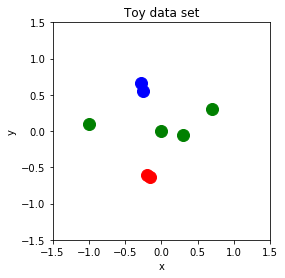

In [6]:
import matplotlib.pyplot as pyplot

%matplotlib inline

def plot_data(features,labels,axis,alpha=1.0):
    # separate features according to their class
    X0,X1,X2 = features[labels==0], features[labels==1], features[labels==2]
    
    # class 0 data
    axis.plot(X0[:,0], X0[:,1], 'o', color='green', markersize=12, alpha=alpha)
    # class 1 data
    axis.plot(X1[:,0], X1[:,1], 'o', color='red', markersize=12, alpha=alpha)
    # class 2 data
    axis.plot(X2[:,0], X2[:,1], 'o', color='blue', markersize=12, alpha=alpha)
    
    # set axes limits
    axis.set_xlim(-1.5,1.5)
    axis.set_ylim(-1.5,1.5)
    axis.set_aspect('equal')
    
    axis.set_xlabel('x')
    axis.set_ylabel('y')

figure,axis = pyplot.subplots(1,1)
plot_data(x,y,axis)
axis.set_title('Toy data set')
pyplot.show()

In the figure above, we can see that two of the classes are represented by two points that are, for each of these classes, very close to each other. The third class, however, has four points that are close to each other with respect to the y-axis, but spread along the x-axis.  

If we were to apply kNN (*k-nearest neighbors*) in a data set like this, we would expect quite some errors using the standard Euclidean distance. This is due to the fact that the spread of the data is not similar amongst the feature dimensions. The following piece of code plots an ellipse on top of the data set. The ellipse in this case is in fact a circunference that helps to visualize how the Euclidean distance weights equally both feature dimensions.   

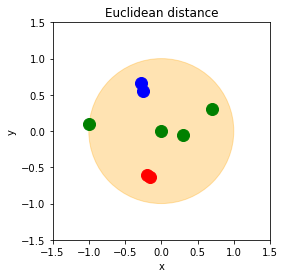

In [7]:
def make_covariance_ellipse(covariance):
    import matplotlib.patches as patches
    import scipy.linalg       as linalg
    
    # the ellipse is centered at (0,0)
    mean = numpy.array([0,0])
    
    # eigenvalue decomposition of the covariance matrix (w are eigenvalues and v eigenvectors),
    # keeping only the real part
    w,v = linalg.eigh(covariance)
    # normalize the eigenvector corresponding to the largest eigenvalue
    u = v[0]/linalg.norm(v[0])
    # angle in degrees
    angle = 180.0/numpy.pi*numpy.arctan(u[1]/u[0])
    # fill Gaussian ellipse at 2 standard deviation
    ellipse = patches.Ellipse(mean, 2*w[0]**0.5, 2*w[1]**0.5, 180+angle, color='orange', alpha=0.3)
    
    return ellipse

# represent the Euclidean distance
figure,axis = pyplot.subplots(1,1)
plot_data(x,y,axis)
ellipse = make_covariance_ellipse(numpy.eye(2))
axis.add_artist(ellipse)
axis.set_title('Euclidean distance')
pyplot.show()


A possible workaround to improve the performance of kNN in a data set like this would be to input to the kNN routine a distance measure. For instance, in the example above a good distance measure would give more weight to the y-direction than to the x-direction to account for the large spread along the x-axis. Nonetheless, it would be nicer (and, in fact, much more useful in practice) if this distance could be learnt automatically from the data at hand. Actually, LMNN is based upon this principle: given a number of neighbours *k*, find the Mahalanobis distance measure which maximizes kNN accuracy (using the given value for *k*) in a training data set. As we usually do in machine learning, under the assumption that the training data is an accurate enough representation of the underlying process, the distance learnt will not only perform well in the training data, but also have good generalization properties.  

Now, let us use the [LMNN class](http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CLMNN.html) implemented in Shogun to find the distance and plot its associated ellipse. If everything goes well, we will see that the new ellipse only overlaps with the data points of the green class.

First, we need to wrap the data into Shogun's feature and label objects:

In [8]:
# from modshogun import RealFeatures, MulticlassLabels

features = x.T;#RealFeatures(x.T)
labels   = y.astype(numpy.float64);#MulticlassLabels(y.astype(numpy.float64))

Secondly, perform LMNN training:

In [9]:
from modshogun import LMNN

# number of target neighbours per example
k = 1

lmnn = LMNN(features,labels,k)
# set an initial transform as a start point of the optimization
init_transform = numpy.eye(2)
lmnn.set_maxiter(2000)
lmnn.train(init_transform)

ModuleNotFoundError: No module named 'modshogun'

LMNN is an iterative algorithm. The argument given to [`train`](http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CLMNN.html#ab1b8bbdb8390415ac3ae7dc655cb512d) represents the initial state of the solution. By default, if no argument is given, then LMNN uses [PCA](http://en.wikipedia.org/wiki/Principal_component_analysis) to obtain this initial value.

Finally, we retrieve the distance measure learnt by LMNN during training and visualize it together with the data:

In [ ]:
# get the linear transform from LMNN
L = lmnn.get_linear_transform()
# square the linear transform to obtain the Mahalanobis distance matrix
M = numpy.matrix(numpy.dot(L.T,L))

# represent the distance given by LMNN
figure,axis = pyplot.subplots(1,1)
plot_data(x,y,axis)
ellipse = make_covariance_ellipse(M.I)
axis.add_artist(ellipse)
axis.set_title('LMNN distance')
pyplot.show()

## Beyond the main idea

LMNN is one of the so-called linear metric learning methods. What this means is that we can understand LMNN's output in two different ways: on the one hand, as a distance measure, this was explained above; on the other hand, as a linear transformation of the input data. Like any other linear transformation, LMNN's output can be written as a matrix, that we will call $L$. In other words, if the input data is represented by the matrix $X$, then LMNN can be understood as the data transformation expressed by $X'=L X$. We use the convention that each column is a feature vector; thus, the number of rows of $X$ is equal to the input dimension of the data, and the number of columns is equal to the number of vectors.

So far, so good. But, if the output of the same method can be interpreted in two different ways, then there must be a relation between them! And that is precisely the case! As mentioned above, the ellipses that were plotted in the previous section represent a distance measure. This distance measure can be thought of as a matrix $M$, being the distance between two vectors $\vec{x_i}$ and $\vec{x_j}$ equal to $d(\vec{x_i},\vec{x_j})=(\vec{x_i}-\vec{x_j})^T M (\vec{x_i}-\vec{x_j})$. In general, this type of matrices are known as *Mahalanobis* matrices. In LMNN, the matrix $M$ is precisely the 'square' of the linear transformation $L$, i.e. $M=L^T L$. Note that a direct consequence of this is that $M$ is guaranteed to be positive semi-definite (PSD), and therefore define a valid metric.

This distance measure/linear transform duality in LMNN has its own advantages. An important one is that the optimization problem can go back and forth between the $L$ and the $M$ representations, giving raise to a very efficient solution.

Let us now visualize LMNN using the linear transform interpretation. In the following figure we have taken our original toy data, transform it using $L$ and plot both the before and after versions of the data together.

In [ ]:
# project original data using L
lx = numpy.dot(L,x.T)

# represent the data in the projected space
figure,axis = pyplot.subplots(1,1)
plot_data(lx.T,y,axis)
plot_data(x,y,axis,0.3)
ellipse = make_covariance_ellipse(numpy.eye(2))
axis.add_artist(ellipse)
axis.set_title('LMNN\'s linear transform')
pyplot.show()

In the figure above, the transparent points represent the original data and are shown to ease the visualization of the LMNN transformation. Note also that the ellipse plotted is the one corresponding to the common Euclidean distance. This is actually an important consideration: if we think of LMNN as a linear transformation, the distance considered in the projected space is the Euclidean distance, and no any Mahalanobis distance given by M. To sum up, we can think of LMNN as a linear transform of the input space, or as method to obtain a distance measure to be used in the input space. It is an error to apply **both** the projection **and** the learnt Mahalanobis distance.  

### Neighbourhood graphs

An alternative way to visualize the effect of using the distance found by LMNN together with kNN consists of using neighbourhood graphs. Despite the fancy name, these are actually pretty simple. The idea is just to construct a graph in the Euclidean space, where the points in the data set are the nodes of the graph, and a directed edge from one point to another denotes that the destination node is the 1-nearest neighbour of the origin node. Of course, it is also possible to work with neighbourhood graphs where $k \gt 1$. Here we have taken the simplification of $k = 1$ so that the forthcoming plots are not too cluttered.

Let us define a data set for which the Euclidean distance performs considerably bad. In this data set there are several levels or layers in the y-direction. Each layer is populated by points that belong to the same class spread along the x-direction. The layers are close to each other in pairs, whereas the spread along x is larger. Let us define a function to generate such a data set and have a look at it.

In [ ]:
import numpy
import matplotlib.pyplot as pyplot
%matplotlib inline

def sandwich_data():
    from numpy.random import normal
    
    # number of distinct classes
    num_classes = 6
    # number of points per class
    num_points = 9
    # distance between layers, the points of each class are in a layer
    dist = 0.7
    
    # memory pre-allocation
    x = numpy.zeros((num_classes*num_points, 2))
    y = numpy.zeros(num_classes*num_points)
    
    for i,j in zip(xrange(num_classes), xrange(-num_classes//2, num_classes//2 + 1)):
        for k,l in zip(xrange(num_points), xrange(-num_points//2, num_points//2 + 1)):
            x[i*num_points + k, :] = numpy.array([normal(l, 0.1), normal(dist*j, 0.1)])
            
        y[i*num_points:i*num_points + num_points] = i
        
    return x,y
    

def plot_sandwich_data(x, y, axis=pyplot, cols=['r', 'b', 'g', 'm', 'k', 'y']):
    for idx,val in enumerate(numpy.unique(y)):
        xi = x[y==val]
        axis.scatter(xi[:,0], xi[:,1], s=50, facecolors='none', edgecolors=cols[idx])

x, y = sandwich_data()
figure, axis = pyplot.subplots(1, 1, figsize=(5,5))
plot_sandwich_data(x, y, axis)

axis.set_aspect('equal')
axis.set_title('"Sandwich" toy data set')
axis.set_xlabel('x')
axis.set_ylabel('y')

pyplot.show()

Let the fun begin now! In the following block of code, we create an instance of a kNN classifier, compute the nearest neighbours using the Euclidean distance and, afterwards, using the distance computed by LMNN. The data set in the space result of the linear transformation given by LMNN is also shown.

In [ ]:
from modshogun import KNN, EuclideanDistance, LMNN, RealFeatures, MulticlassLabels

def plot_neighborhood_graph(x, nn, axis=pyplot, cols=['r', 'b', 'g', 'm', 'k', 'y']):
	for i in xrange(x.shape[0]):
		xs = [x[i,0], x[nn[1,i], 0]]
		ys = [x[i,1], x[nn[1,i], 1]]
		axis.plot(xs, ys, cols[int(y[i])])

features = RealFeatures(x.T)
labels = MulticlassLabels(y)

fig, axes = pyplot.subplots(1, 3, figsize=(15, 10))

# use k = 2 instead of 1 because otherwise the method nearest_neighbors just returns the same
# points as their own 1-nearest neighbours
k = 2

knn = KNN(k, EuclideanDistance(features, features), labels)

plot_sandwich_data(x, y, axes[0])
plot_neighborhood_graph(x, knn.nearest_neighbors(), axes[0])
axes[0].set_title('Euclidean neighbourhood in the input space')

lmnn = LMNN(features, labels, k)
# set a large number of iterations. The data set is small so it does not cost a lot, and this way
# we ensure a robust solution
lmnn.set_maxiter(3000)
lmnn.train()
knn.set_distance(lmnn.get_distance())

plot_sandwich_data(x, y, axes[1])
plot_neighborhood_graph(x, knn.nearest_neighbors(), axes[1])
axes[1].set_title('LMNN neighbourhood in the input space')

# plot features in the transformed space, with the neighbourhood graph computed using the Euclidean distance
L = lmnn.get_linear_transform()
xl = numpy.dot(x, L.T)
features = RealFeatures(xl.T)
knn.set_distance(EuclideanDistance(features, features))

plot_sandwich_data(xl, y, axes[2])
plot_neighborhood_graph(xl, knn.nearest_neighbors(), axes[2])
axes[2].set_ylim(-3, 2.5)
axes[2].set_title('Euclidean neighbourhood in the transformed space')

[axes[i].set_xlabel('x') for i in xrange(len(axes))]
[axes[i].set_ylabel('y') for i in xrange(len(axes))]
[axes[i].set_aspect('equal') for i in xrange(len(axes))]

pyplot.show()

Notice how all the lines that go across the different layers in the left hand side figure have disappeared in the figure in the middle. Indeed, LMNN did a pretty good job here. The figure in the right hand side shows the disposition of the points in the transformed space; from which the neighbourhoods in the middle figure should be clear. In any case, this toy example is just an illustration to give an idea of the power of LMNN. In the next section we will see how after applying a couple methods for feature normalization (e.g. scaling, whitening) the Euclidean distance is not so sensitive against different feature scales.

## Real data sets

### Feature selection in metagenomics

Metagenomics is a modern field in charge of the study of the DNA of microorganisms. The data set we have chosen for this section contains information about three different types of apes; in particular, gorillas, chimpanzees, and bonobos. Taking an approach based on metagenomics, the main idea is to study the DNA of the microorganisms (e.g. bacteria) which live inside the body of the apes. Owing to the many chemical reactions produced by these microorganisms, it is not only the DNA of the host itself important when studying, for instance, sickness or health, but also the DNA of the microorganisms inhabitants.

First of all, let us load the ape data set. This data set contains features taken from the bacteria inhabitant in the gut of the apes.

In [ ]:
from modshogun import CSVFile, RealFeatures, MulticlassLabels

ape_features = RealFeatures(CSVFile('../../../data/multiclass/fm_ape_gut.dat'))
ape_labels = MulticlassLabels(CSVFile('../../../data/multiclass/label_ape_gut.dat'))

It is of course important to have a good insight of the data we are dealing with. For instance, how many examples and different features do we have?

In [ ]:
print('Number of examples = %d, number of features = %d.' % (ape_features.get_num_vectors(), ape_features.get_num_features()))

So, 1472 features! Those are quite many features indeed. In other words, the feature vectors at hand lie on a 1472-dimensional space. We cannot visualize in the input feature space how the feature vectors look like. However, in order to gain a little bit more of understanding of the data, we can apply dimension reduction, embed the feature vectors in a two-dimensional space, and plot the vectors in the embedded space. To this end, we are going to use one of the [many](http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CEmbeddingConverter.html) methods for dimension reduction included in Shogun. In this case, we are using t-distributed stochastic neighbour embedding (or [t-dsne](http://jmlr.org/papers/v9/vandermaaten08a.html)). This method is particularly suited to produce low-dimensional embeddings (two or three dimensions) that are straightforward to visualize.

In [ ]:
def visualize_tdsne(features, labels):
    from modshogun import TDistributedStochasticNeighborEmbedding
    
    converter = TDistributedStochasticNeighborEmbedding()
    converter.set_target_dim(2)
    converter.set_perplexity(25)
    
    embedding = converter.embed(features)
    
    import matplotlib.pyplot as pyplot
    % matplotlib inline
    
    x = embedding.get_feature_matrix()
    y = labels.get_labels()
    
    pyplot.scatter(x[0, y==0], x[1, y==0], color='green')
    pyplot.scatter(x[0, y==1], x[1, y==1], color='red')
    pyplot.scatter(x[0, y==2], x[1, y==2], color='blue')
    pyplot.show()
    
visualize_tdsne(ape_features, ape_labels)

In the figure above, the green points represent chimpanzees, the red ones bonobos, and the blue points gorillas. Providing the results in the figure, we can rapidly draw the conclusion that the three classes of apes are somewhat easy to discriminate in the data set since the classes are more or less well separated in two dimensions. Note that t-dsne use randomness in the embedding process. Thus, the figure result of the experiment in the previous block of code will be different after different executions. Feel free to play around and observe the results after different runs! After this, it should be clear that the bonobos form most of the times a very compact cluster, whereas the chimpanzee and gorillas clusters are more spread. Also, there tends to be a chimpanzee (a green point) closer to the gorillas' cluster. This is probably a outlier in the data set.

Even before applying LMNN to the ape gut data set, let us apply kNN classification and study how it performs using the typical Euclidean distance. Furthermore, since this data set is rather small in terms of number of examples, the kNN error above may vary considerably (I have observed variation of almost 20% a few times) across different runs. To get a robust estimate of how kNN performs in the data set, we will perform cross-validation using [Shogun's framework](http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CCrossValidation.html) for evaluation. This will give us a reliable result regarding how well kNN performs in this data set.

In [ ]:
from modshogun import KNN, EuclideanDistance
from modshogun import StratifiedCrossValidationSplitting, CrossValidation
from modshogun import CrossValidationResult, MulticlassAccuracy

# set up the classifier
knn = KNN()
knn.set_k(3)
knn.set_distance(EuclideanDistance())

# set up 5-fold cross-validation
splitting = StratifiedCrossValidationSplitting(ape_labels, 5)
# evaluation method
evaluator = MulticlassAccuracy()
cross_validation = CrossValidation(knn, ape_features, ape_labels, splitting, evaluator)
# locking is not supported for kNN, deactivate it to avoid an inoffensive warning
cross_validation.set_autolock(False)
# number of experiments, the more we do, the less variance in the result
num_runs = 200
cross_validation.set_num_runs(num_runs)

# perform cross-validation and print the result!
result = cross_validation.evaluate()
result = CrossValidationResult.obtain_from_generic(result)
print('kNN mean accuracy in a total of %d runs is %.4f.' % (num_runs, result.mean))


Finally, we can say that KNN performs actually pretty well in this data set. The average test classification error is less than between 2%. This error rate is already low and we should not really expect a significant improvement applying LMNN. This ought not be a surprise. Recall that the points in this data set have more than one thousand features and, as we saw before in the dimension reduction experiment, only two dimensions in an embedded space were enough to discern arguably well the chimpanzees, gorillas and bonobos.

Note that we have used stratified splitting for cross-validation. Stratified splitting divides the folds used during cross-validation so that the proportion of the classes in the initial data set is approximately maintained for each of the folds. This is particular useful in *skewed* data sets, where the number of examples among classes varies significantly.

Nonetheless, LMNN may still turn out to be very useful in a data set like this one. Making a small modification of the vanilla LMNN algorithm, we can enforce that the linear transform found by LMNN is diagonal. This means that LMNN can be used to weight each of the features and, once the training is performed, read from these weights which features are relevant to apply kNN and which ones are not. This is indeed a form of *feature selection*. Using Shogun, it is extremely easy to switch to this so-called *diagonal* mode for LMNN: just call the method [`set_diagonal(use_diagonal)`](http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CLMNN.html#ad2f03dbad3ad08ab76aecbb656a486e6) with `use_diagonal` set to `True`.

The following experiment takes about five minutes until it is completed (using Shogun Release, i.e. compiled with optimizations enabled). This is mostly due to the high dimension of the data (1492 features) and the fact that, during training, LMNN has to compute many outer products of feature vectors, which is a computation whose time complexity is proportional to the square of the number of features. For the illustration purposes of this notebook, in the following cell we are just going to use a small subset of all the features so that the training is finished in a few seconds.

In [ ]:
from modshogun import LMNN
import numpy

# to make training faster, use a portion of the features
fm = ape_features.get_feature_matrix()
ape_features_subset = RealFeatures(fm[:300, :])

# number of targer neighbours in LMNN, here we just use the same value that was used for KNN before
k = 3
lmnn = LMNN(ape_features_subset, ape_labels, k)
lmnn.set_diagonal(True)
lmnn.set_maxiter(1200)
init_transform = numpy.eye(ape_features_subset.get_num_features())
lmnn.train(init_transform)

diagonal = numpy.diag(lmnn.get_linear_transform())
print('%d out of %d elements are non-zero.' % (numpy.sum(diagonal != 0), diagonal.size))

So only 65 out of the 300 first features are important according to the result transform! The rest of them have been given a weight exactly equal to zero, even if all of the features were weighted equally with a value of one at the beginnning of the training. In fact, if all the 1472 features were used, only about 158 would have received a non-zero weight. Please, feel free to experiment using all the features!

It is a fair question to ask how did we know that the maximum number of iterations in this experiment should be around 1200 iterations. Well, the truth is that we know this only because we have run this experiment with this same data beforehand, and we know that after this number of iterations the algorithm has converged. This is not something nice, and the ideal case would be if one could completely forget about this parameter, so that LMNN uses as many iterations as it needs until it converges. Nevertheless, this is not practical at least because of two reasons:

- If you are dealing with many examples or with very high dimensional feature vectors, you might not want to wait until the algorithm converges and have a look at what LMNN has found before it has completely converged.
- As with any other algorithm based on gradient descent, the termination criteria can be tricky. Let us illustrate this further:

In [ ]:
import matplotlib.pyplot as pyplot
%matplotlib inline

statistics = lmnn.get_statistics()
pyplot.plot(statistics.obj.get())
pyplot.grid(True)
pyplot.xlabel('Number of iterations')
pyplot.ylabel('LMNN objective')
pyplot.show()

Along approximately the first three hundred iterations, there is not much variation in the objective. In other words, the objective curve is pretty much flat. If we are not careful and use termination criteria that are not demanding enough, training could be stopped at this point. This would be wrong, and might have terrible results as the training had not clearly converged yet at that moment.

In order to avoid disastrous situations, in Shogun we have implemented LMNN with really demanding criteria for automatic termination of the training process. Albeit, it is possible to tune the termination criteria using the methods [`set_stepsize_threshold`](http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CLMNN.html#a76b6914cf9d1a53b0c9ecd828c7edbcb) and [`set_obj_threshold`](http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CLMNN.html#af78c7dd9ed2307c0d53e7383cdc01a24). These methods can be used to modify the lower bound required in the step size and the increment in the objective (relative to its absolute value), respectively, to stop training. Also, it is possible to set a hard upper bound on the number of iterations using [`set_maxiter`](http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CLMNN.html#afcf319806eb710a0d9535fbeddf93795) as we have done above. In case the internal termination criteria did not fire before the maximum number of iterations was reached, you will receive a warning message, similar to the one shown above. This is not a synonym that the training went wrong; but it is strongly recommended at this event to have a look at the objective plot as we have done in the previous block of code.

### Multiclass classification

In addition to feature selection, LMNN can be of course used for multiclass classification. I like to think about LMNN in multiclass classification as a way to empower kNN. This is, the idea is basically to apply kNN using the distance found by LMNN $-$ in contrast with using one of the other most common distances, such as the Euclidean one. To this end we will use the wine data set from the [UCI Machine Learning repository](http://archive.ics.uci.edu/ml/datasets/Wine "Wine data set").

In [ ]:
from modshogun import CSVFile, RealFeatures, MulticlassLabels

wine_features = RealFeatures(CSVFile('../../../data/multiclass/fm_wine.dat'))
wine_labels = MulticlassLabels(CSVFile('../../../data/multiclass/label_wine.dat'))

assert(wine_features.get_num_vectors() == wine_labels.get_num_labels())
print('%d feature vectors with %d features from %d different classes.' % (wine_features.get_num_vectors(), \
       wine_features.get_num_features(), wine_labels.get_num_classes()))

First, let us evaluate the performance of kNN in this data set using the same cross-validation setting used in the previous section:

In [ ]:
from modshogun import KNN, EuclideanDistance
from modshogun import StratifiedCrossValidationSplitting, CrossValidation
from modshogun import CrossValidationResult, MulticlassAccuracy
import numpy

# kNN classifier
k = 5
knn = KNN()
knn.set_k(k)
knn.set_distance(EuclideanDistance())

splitting = StratifiedCrossValidationSplitting(wine_labels, 5)
evaluator = MulticlassAccuracy()
cross_validation = CrossValidation(knn, wine_features, wine_labels, splitting, evaluator)
cross_validation.set_autolock(False)
num_runs = 200
cross_validation.set_num_runs(num_runs)

result = CrossValidationResult.obtain_from_generic(cross_validation.evaluate())
euclidean_means = numpy.zeros(3)
euclidean_means[0] = result.mean

print('kNN accuracy with the Euclidean distance %.4f.' % result.mean)

Seconly, we will use LMNN to find a distance measure and use it with kNN:

In [ ]:
from modshogun import LMNN

# train LMNN
lmnn = LMNN(wine_features, wine_labels, k)
lmnn.set_maxiter(5000)
lmnn.train()

# evaluate kNN using the distance learnt by LMNN
knn.set_distance(lmnn.get_distance())

result = CrossValidationResult.obtain_from_generic(cross_validation.evaluate())
lmnn_means = numpy.zeros(3)
lmnn_means[0] = result.mean

print('kNN accuracy with the distance obtained by LMNN %.4f.' % result.mean)

The warning is fine in this case, we have made sure that the objective variation was really small after 5000 iterations. In any case, do not hesitate to check it yourself studying the objective plot as it was shown in the previous section.

As the results point out, LMNN really helps here to achieve better classification performance. However, this comparison is not entirely fair since the Euclidean distance is very sensitive to the scaling that different feature dimensions may have, whereas LMNN can adjust to this during training. Let us have a closer look to this fact. Next, we are going to retrieve the feature matrix and see what are the maxima and minima for every dimension.

In [ ]:
print('minima = ' + str(numpy.min(wine_features, axis=1)))
print('maxima = ' + str(numpy.max(wine_features, axis=1)))

Examine the second and the last dimensions, for instance. The second dimension has values ranging from 0.74 to 5.8, while the values of the last dimension range from 278 to 1680. This will cause that the Euclidean distance works specially wrong in this data set. You can realize of this considering that the total distance between two points will almost certainly just take into account the contributions of the dimensions with largest range.

In order to produce a more fair comparison, we will rescale the data so that all the feature dimensions are within the interval [0,1]. Luckily, there is a [preprocessor](http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CPreprocessor.html) class in Shogun that makes this straightforward.

In [ ]:
from modshogun import RescaleFeatures

# preprocess features so that all of them vary within [0,1]
preprocessor = RescaleFeatures()
preprocessor.init(wine_features)
wine_features.add_preprocessor(preprocessor)
wine_features.apply_preprocessor()

# sanity check
feature_matrix = wine_features.get_feature_matrix()
assert(numpy.min(wine_features) >= 0.0 and numpy.max(wine_features) <= 1.0)

# perform kNN classification after the feature rescaling
knn.set_distance(EuclideanDistance())
result = CrossValidationResult.obtain_from_generic(cross_validation.evaluate())
euclidean_means[1] = result.mean

print('kNN accuracy with the Euclidean distance after feature rescaling %.4f.' % result.mean)

# train kNN in the new features and classify with kNN
lmnn.train()
knn.set_distance(lmnn.get_distance())
result = CrossValidationResult.obtain_from_generic(cross_validation.evaluate())
lmnn_means[1] = result.mean

print('kNN accuracy with the distance obtained by LMNN after feature rescaling %.4f.' % result.mean)

Another different preprocessing that can be applied to the data is called *whitening*. Whitening, which is explained in an [article in wikipedia](http://en.wikipedia.org/wiki/Whitening_transformation "Whitening transform"), transforms the covariance matrix of the data into the identity matrix.

In [ ]:
import scipy.linalg as linalg

# shorthand for the feature matrix -- this makes a copy of the feature matrix
data = wine_features.get_feature_matrix()
# remove mean
data = data.T
data-= numpy.mean(data, axis=0)
# compute the square of the covariance matrix and its inverse
M = linalg.sqrtm(numpy.cov(data.T))
# keep only the real part, although the imaginary that pops up in the sqrtm operation should be equal to zero
N = linalg.inv(M).real
# apply whitening transform
white_data = numpy.dot(N, data.T)
wine_white_features = RealFeatures(white_data)

The covariance matrices before and after the transformation can be compared to see that the covariance really becomes the identity matrix.

In [ ]:
import matplotlib.pyplot as pyplot
%matplotlib inline

fig, axarr = pyplot.subplots(1,2)
axarr[0].matshow(numpy.cov(wine_features))
axarr[1].matshow(numpy.cov(wine_white_features))
pyplot.show()

Finally, we evaluate again the performance obtained with kNN using the Euclidean distance and the distance found by LMNN using the whitened features.

In [ ]:
wine_features = wine_white_features

# perform kNN classification after whitening
knn.set_distance(EuclideanDistance())
result = CrossValidationResult.obtain_from_generic(cross_validation.evaluate())
euclidean_means[2] = result.mean

print('kNN accuracy with the Euclidean distance after whitening %.4f.' % result.mean)

# train kNN in the new features and classify with kNN
lmnn.train()
knn.set_distance(lmnn.get_distance())
result = CrossValidationResult.obtain_from_generic(cross_validation.evaluate())
lmnn_means[2] = result.mean

print('kNN accuracy with the distance obtained by LMNN after whitening %.4f.' % result.mean)

As it can be seen, it did not really help to whiten the features in this data set with respect to only applying feature rescaling; the accuracy was already rather large after rescaling. In any case, it is good to know that this transformation exists, as it can become useful with other data sets, or before applying other machine learning algorithms.

Let us summarize the results obtained in this section with a bar chart grouping the accuracy results by distance (Euclidean or the one found by LMNN), and feature preprocessing:

In [ ]:
assert(euclidean_means.shape[0] == lmnn_means.shape[0])
N = euclidean_means.shape[0]
# the x locations for the groups
ind = 0.5*numpy.arange(N)
# bar width
width = 0.15
figure, axes = pyplot.subplots()

euclidean_rects = axes.bar(ind, euclidean_means, width, color='y')
lmnn_rects = axes.bar(ind+width, lmnn_means, width, color='r')

# attach information to chart
axes.set_ylabel('Accuracies')
axes.set_ylim(top=1.4)
axes.set_title('kNN accuracy by distance and feature preprocessing')
axes.set_xticks(ind+width)
axes.set_xticklabels(('Raw', 'Rescaling', 'Whitening'))
axes.legend(( euclidean_rects[0], lmnn_rects[0]), ('Euclidean', 'LMNN'), loc='upper right')

def autolabel(rects):
    # attach text labels to bars
    for rect in rects:
        height = rect.get_height()
        axes.text(rect.get_x()+rect.get_width()/2., 1.05*height, '%.3f' % height,
                  ha='center', va='bottom')
        
autolabel(euclidean_rects)
autolabel(lmnn_rects)

pyplot.show()

## References

- Weinberger, K. Q., Saul, L. K. Distance Metric Learning for Large Margin Nearest Neighbor Classification. [(Link to paper in JMLR)](http://jmlr.org/papers/v10/weinberger09a.html).